### Week 10: Logistic regression

By Charlie Eaton and Albina Gibadullina

April 2, 2020

1. Reactions to "The Social Circuitry of High Finance"
2. Probabilities and odds ratios
3. The Maximum Likelihood Estimation (MLE) intuition of logistic regression
4. The magic of logs revisited: Log Likelihoods
5. The MLE logistic equation to maxamize log likelihoods
6. Implementing & Interpreting MLE logistic regression in Stata
7. Postestimation and robustness

### 1. "The Social Circuitry of High Finance"

In [1]:
set more off
*log using w10lesson_MLE_logistic20200401.log
use socialcircuitrybillionaires, clear
describe


Contains data from socialcircuitrybillionaires.dta
 Observations:         1,200                  
    Variables:             6                  1 Apr 2020 01:18
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
year            float   %10.0g                year of observation
boardtop30pri~e float   %9.0g                 held seat on top 30 private
                                                university board
inherited       float   %9.0g                 in Forbes inherited wealth
                                                category
collegeschool~e float   %9.0g                 BA school elite status 0 to 3
id              float   %9.0g                 person-level unique ID
pehedge         float   %9.0g                 private equity or hedge fund
                     

In [2]:
%head

,year,boardtop30private,inherited,collegeschooltype,id,pehedge
1,1989,0,0,0,865,0
2,1989,0,0,2,767,0
3,1989,0,1,0,662,0
4,1989,0,0,1,298,0
5,1989,0,0,1,446,0


### 2. Probabilities and odds ratios

* A. With a dichotomous (binary) dependent variable Y, we cannot assume that regression residuals (errors of prediction) are normally distributed as OLS requires. And OLS will predict non-sensical values for Y (outside of the range of 0 to 1)

* B. Instead, logistic regression predicts the logit of dependent variable Y (aka the log of the odds ratio for Y=1) for each observation based on independent variables: $ X_1 ... X_k $

* C. Odds ratios are an expression of the probability that Y=1 is true.

An example from "Social Circuitry":

* Y is a dichotomous/binary dependent variable

* Y = 1 if the Forbes 400 billionaire serves on the board of a top 30 private university that year, and is otherwise 0

* The unconditioned probability that Y=1 is estimated as follows:

### $ p=P(Y=1) = {f_{Y=1} \over N} $

We can estimate probability with a frequency table:

In [3]:
tab boardtop30private pehedge, column


+-------------------+
| Key               |
|-------------------|
|     frequency     |
| column percentage |
+-------------------+

 held seat |
 on top 30 |
   private |   private equity or
university |  hedge fund partner
     board |         0          1 |     Total
-----------+----------------------+----------
         0 |       952         94 |     1,046 
           |     88.81      73.44 |     87.17 
-----------+----------------------+----------
         1 |       120         34 |       154 
           |     11.19      26.56 |     12.83 
-----------+----------------------+----------
     Total |     1,072        128 |     1,200 
           |    100.00     100.00 |    100.00 


### From probability to an odds ratio:

* An odds ratio is the probability of something being true divided by the probability that it is not true.

* The formula for an odds ratio is:

### $ OR = {p \over (1-p)} $

We can write this in Stata:

In [4]:
display "OR = p / (1-p) = " .1283 / (1-.1283)
display "OR = (fy=1 / fy=0) = " 154 / 1046

OR = p / (1-p) = .14718366
OR = (fy=1 / fy=0) = .14722753


### 3. The Maximum Likelihood Estimation (MLE) intuition of logistic regression

* The principle "is to find the value of the "coefficient" that maximizes the likelihood of observing all of the sample data." (Treiman pg. 302)

* This means our model and coefficients predict the **"likelihood"** of Y=1 rather than the value of Y for each observation.

* Think of every observation of Y -- whether they are on a top university board -- for every billionaire in our dataset as involving a flip of a coin resulting in Heads, Y=yes, or Tails, Y=No.

* But the coin toss is never really fair because the coin is weighted.

* We estimate coefficients for our independent variables in logistic regression to predict how much weight towards yes or no (i.e. probability of yes or no) for each billionaire would give us the **Maximum Likelihood** of observing all of our exact data.

* As shown above, among billionaires there is .128 rate of being on top university boards. But among **private equity or hedge fund billionaires** there is a .26 rate. Here is how it would look in Stata if we did 100 flips of a coin that was weighted according to these probabilities:

In [5]:
quietly net install heads, from(https://stats.idre.ucla.edu/stat/stata/ado/teach)

In [6]:
set scheme plotplainblind

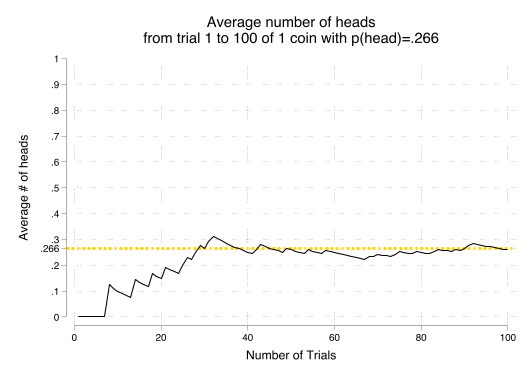

In [7]:
quietly heads, flips(100) prob(.128) 
quietly graph save plainbillionaires, replace

quietly heads, flips(100) prob(.266)
quietly graph save pehedgebillionaires, replace

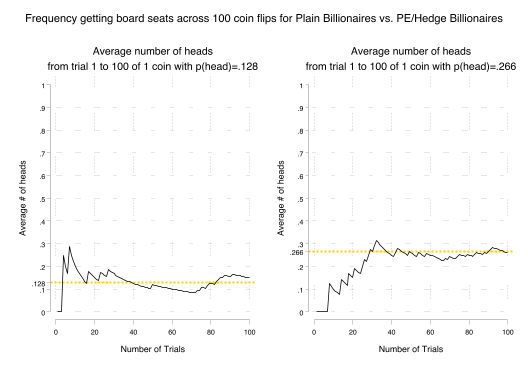

In [8]:
graph combine plainbillionaires.gph pehedgebillionaires.gph, ysize(6) xsize(12) iscale(.95) ///
title("Frequency getting board seats across 100 coin flips for Plain Billionaires vs. PE/Hedge Billionaires", size(medlarge))

### 4. The magic of logs revisited: Log Likelihoods (logits)

* Log likelihoods (logits) are the log of the odds ratio for y = 1, which logistic regression models in relationship to X covariates as follows:

## $ \log_e(\frac{p_y}{1-p_y}) = \alpha + \beta_1 x_1 + ... \beta_2 x_K $

* We can flip this around to visually think about the intuition of the logistic model:

## $ p_y = \frac{1}{1+e^{\alpha + \beta_1 * -x}} $

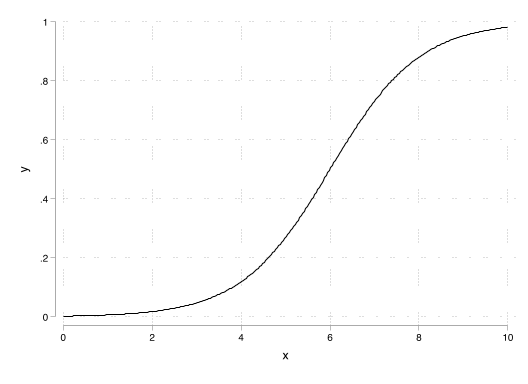

In [9]:
tw (function y = 1/(1+exp(6 + -x)), range(0 10))

* this is more realistice than a linear OLS model that would predict observed values greater than 1 and less than zero for Y, which is non-sensical. See https://www.sciencedirect.com/science/article/abs/pii/S0165176505003150 and https://www.stata.com/meeting/us20/slides/us20_Allison.pdf

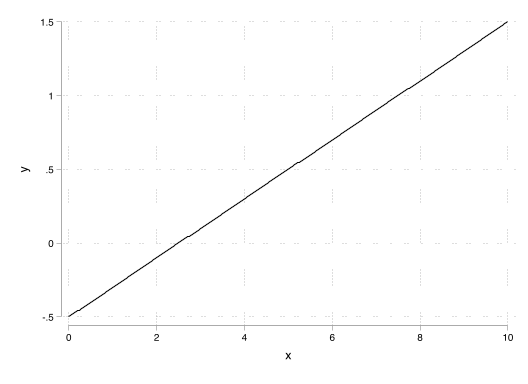

In [10]:
tw (function y = -.5 + .2*x , range(0 10))

* Maximum Likelihood Estimation (MLE) typically uses log likelihoods in part because logs make calculations easier for humans and computers, especially when it comes to very small probabilities.

* To see this, **try using the calculator on your computer to multiply .01^25 * .01^25.** This is equivalent to multiplying .01 by itself 50 times.

* Logs also have handy properties such as the log of a product, i.e. log(X * Y) being equal to the sum of the logs, i.e. log(X) + log(Y). For example:

In [11]:
display "log(10 * 10) = " log(.0001*.0001)
display "log(10) + log(10) = " log(.0001) + log(.0001)

log(10 * 10) = -18.420681
log(10) + log(10) = -18.420681


### 5. The Maximum Likeihood Estimation (MLE) logistic equation to maximize log likelihoods

* The MLE logit model equation predicts a logit (aka log odds) for each observation as the log of the odds ratio for the probability that Y=1 ( $ p = p_{Y=1} $ ):

### logit (aka log odds) = $ \log_e(OR) = \log_e(\frac{p}{1-p}) = \alpha + \beta_1 x_1 + ... \beta_2 x_K $

* MLE then estimates which coefficients maximize the sum of **log likelihoods** from each observation for the whole dataset.

* MLE does this by predicting logits that express probabilities for Y=1 (and thus also for Y=0) for each observation.

* We convert those probabilities to log likelihoods (log of probabilities) because we can the calculate the overall probability for what we see in the neighborhood by summing legible log likelihoods instead of multiplying probabilities for each observation to yield very small maximum probabilities for what we observe.

### For example, consider what we have for observed outcomes, maximimizing probabilities, and and maximizing log liklihoods for three observations in the billionaire data: 
    * Y=1, p(y=1)=.394, log(.394)=-.93
    * Y=0, p(y=0)=.866, log(.866)=-.14 
    * Y=1, p(y=1)=.171, log(.171)=-1.77

* The log likelihoods are negative because the maximum probability possible is 1. And log likelihoods are the power to which you would need to raise $ e $ to get the probability below 1. This requires raising $ e $ to a negative number. For example, e^-.14... = .866. The negative exponent notation signifies that $ \frac{1}{e^.14} = .866 $ FYI: e^.14 equals 1.15 as the 1/.14 root or 7th root of e (meaning 1.15^7 ~= e)

* The overall probability for what we observe in the 3 observations is .394 * .866 * .171 = .058
    
* When you multiply probabilities for what is observed in the whole billionaire dataset, the probability of what we observe is 1.6 X 10^-181. In other words it is a probability of zero point 181 zeros 16

* As noted above, it's easier for humans and the computers to compute and read the overall log likelihood for everything observed in the data.

* The overall log likelihood for the 3 observations is -.93 + -.14 + -.177 = -2.84.

* Magically ln(.058) = -2.84 and e^-2.84 = .058. 

## The procedures for estimating the logit can be derived from the painful algebraic explanation of the MLE logit model that follows.

It should make more sense in a moment when I will illustrate it in an interactive Excel worksheet.


### $ \frac{p}{1-p} = e^{\alpha + \beta_1 x_1 + ... \beta_2 x_K} $

* further therefore:

### $ {p} = e^{\alpha...} - p \cdot e^{\alpha...}  $
### $ {p} + p \cdot e^{\alpha...} = e^{\alpha...} $
### $ {p} \cdot (1 + e^{\alpha...}) = e^{\alpha...} $
### $ {p} = \frac{e^{\alpha...}}{1 + e^{\alpha...}} $

* The log likelihood for Y=1 | Y=0 based on the logit for **each observation** is then:


### $ {Y} \cdot \ln{\frac{e^{\alpha...}}{1 + e^{\alpha...}}} + (1-Y) \cdot \ln{(1 - \frac{e^{\alpha...}}{1 + e^{\alpha...}})}   $

* So that if Y=1, the higher the logit the higher the log likelihood, but if Y=0, the higher the logit the lower the log likelihood.

* The logistic MLE estimation then iteratively adjusts each regression coefficient upwards and downwards until converging on a coefficient that maximizes the sum of log likelihoods for all observations:

### $  \sum_{i=1}^N {Y_i} \cdot \ln{\frac{e^{\alpha...}}{1 + e^{\alpha...}}} + (1-Y_i) \cdot \ln{(1 - \frac{e^{\alpha...}}{1 + e^{\alpha...}})} $

* Now let's check this out in an interactive spreadsheet. Your task in the spreadsheet is adjust each regression coefficient by hand to maximize the sum of log likelihooks. The worksheet is here: https://github.com/charlieeatonphd/gradstats2/blob/master/week10/socialcircuitry.xlsx

### 6. Implementing & Interpreting MLE logistic regression in Stata

* Lets see how the coefficients estimated by Stata compare to what we estimated by hand:

In [12]:
logit boardtop30private pehedge inherited collegeschooltype, robust


Iteration 0:   log pseudolikelihood = -459.84734  
Iteration 1:   log pseudolikelihood =  -420.6123  
Iteration 2:   log pseudolikelihood = -416.17173  
Iteration 3:   log pseudolikelihood = -416.16029  
Iteration 4:   log pseudolikelihood = -416.16029  

Logistic regression                                     Number of obs =  1,200
                                                        Wald chi2(3)  =  76.99
                                                        Prob > chi2   = 0.0000
Log pseudolikelihood = -416.16029                       Pseudo R2     = 0.0950

------------------------------------------------------------------------------
             |               Robust
boardtop30~e | Coefficient  std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
     pehedge |    .762881   .2308848     3.30   0.001     .3103552    1.215407
   inherited |  -.3198332   .2027999    -1.58   0.115    -.7173137    .077

### But what do these coefficients mean?

* The coefficients are the amount of change expected in the log of the odds ratio for Y=1 for every 1 unit change in X.

* Thinking about the meaning of the coefficents makes my head hurt. One way to interpret them is to convert them to **odds ratios.**

* To convert the coefficient to an odds ratio we exponentiate the coefficient (aka take the antilog) as follows:

###  $ \log_e(OR) = \log_e(\frac{p}{1-p}) = \alpha + \beta_1 x_1 + ... \beta_2 x_K $

therefore:

### $ \log_e(OR_\beta{x_1}) = \beta{x_1} $

further therefore:

### $ OR_\beta{x_1} = e^{\beta{x_1}} $

* Or in Stata:

In [13]:
display "OR for beta(pe_hedge) = e^.762881 = " exp(.762881)

OR for beta(pe_hedge) = e^.762881 = 2.1444455


* Or we can get **Odds Ratios** directly from the logistic regression command the **"or"** specification:

In [14]:
logit boardtop30private pehedge inherited collegeschooltype, or robust


Iteration 0:   log pseudolikelihood = -459.84734  
Iteration 1:   log pseudolikelihood =  -420.6123  
Iteration 2:   log pseudolikelihood = -416.17173  
Iteration 3:   log pseudolikelihood = -416.16029  
Iteration 4:   log pseudolikelihood = -416.16029  

Logistic regression                                     Number of obs =  1,200
                                                        Wald chi2(3)  =  76.99
                                                        Prob > chi2   = 0.0000
Log pseudolikelihood = -416.16029                       Pseudo R2     = 0.0950

------------------------------------------------------------------------------
             |               Robust
boardtop30~e | Odds ratio   std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
     pehedge |   2.144446   .4951198     3.30   0.001      1.36391    3.371666
   inherited |   .7262701   .1472875    -1.58   0.115     .4880616    1.08

### 7. Problems with Odd Ratios: Postestimation and robustness

* An anonymous journal reviewer once wrote to me that "One cannot straightforwardly interpret log-odds as effect measures (because they also reflect the degree of unobserved heterogeneity in the model)... I strongly suggest to report average marginal effects that provide readily interpretable effect estimates (see Breen/Karlson/Holm 2018)." See https://www.annualreviews.org/doi/10.1146/annurev-soc-073117-041429

* Postestimation and robustness precautions are similar to those that apply for OLS regression

* Standard error estimates are evaluated with a Z test rather than a t-test for which P-values have equivalent meanings to their counterparts in OLS.

* You similarly should specify robust or cluster robust standard errors.

* You can also report stored estimates in tables equivalently using esttab. In doing so, for example, we can compare how OLS, MLE without average marginal effects, and MLE with average marginal effects postestimation yield meaningfully different estimates for university board membership by billionaires:

In [15]:
est clear

quietly eststo: regress boardtop30private pehedge inherited collegeschooltype i.year, cluster(id) ro
quietly eststo: logit boardtop30private pehedge inherited collegeschooltype i.year, cluster(id) ro
quietly eststo: margins, dydx(*) post atmeans

In [16]:
esttab ///
, cells(b(star fmt(2)) se(fmt(2) par)) stardetach  ///
	legend starlevels(^ .1 * .05 ** .01 *** .001) ///
mlabels("OLS" "MLE / logistic" "MLE marginal effects") title("unexpontiated coefficients") ///
collabels(none) keep(pehedge inherited collegeschooltype _cons)


unexpontiated coefficients
---------------------------------------------------------------
                      (1)              (2)              (3)    
                      OLS     MLE / logi~c     MLE margin~s    
---------------------------------------------------------------
main                                                           
pehedge              0.11 *           0.71 *           0.06 *  
                   (0.05)           (0.31)           (0.03)    
inherited           -0.04 *          -0.45 *          -0.04 *  
                   (0.02)           (0.22)           (0.02)    
collegesch~e         0.07 ***         0.68 ***         0.06 ***
                   (0.01)           (0.12)           (0.01)    
_cons                0.00            -3.42 ***                 
                   (0.02)           (0.31)                     
---------------------------------------------------------------
N                    1200             1200             1200    
------------

### adding **"eform"** to esttab specifies that you want to output odds ratios: 

In [18]:
esttab ///
, cells(b(star fmt(2)) se(fmt(2) par)) stardetach  ///
	legend starlevels(^ .1 * .05 ** .01 *** .001) ///
mlabels("OLS" "MLE / logistic" "MLE Marginal Effects") title("Odds Ratios") ///
collabels(none) keep(pehedge inherited collegeschooltype _cons) eform


Odds Ratios
---------------------------------------------------------------
                      (1)              (2)              (3)    
                      OLS     MLE / logi~c     MLE Margin~s    
---------------------------------------------------------------
main                                                           
pehedge              1.11 *           2.04 *           1.07 *  
                   (0.06)           (0.63)           (0.03)    
inherited            0.96 *           0.64 *           0.96 *  
                   (0.02)           (0.14)           (0.02)    
collegesch~e         1.07 ***         1.97 ***         1.06 ***
                   (0.01)           (0.24)           (0.01)    
---------------------------------------------------------------
N                    1200             1200             1200    
---------------------------------------------------------------
Exponentiated coefficients
^ p<.1, * p<.05, ** p<.01, *** p<.001
